In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras.layers as layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint

2024-05-03 12:29:46.082586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 12:29:46.082710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 12:29:46.220448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# electrode_names = [
#     "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
#     "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
#     "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
#     "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
#     "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
#     "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
#     "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
#     "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
#     "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
#     "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
#     "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
#     "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
#     "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
# ]

# num_electrodes = len(electrode_names)

NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167
BATCH_SIZE = 128

In [3]:
def load_in_order(cz: int):
    dataset = np.zeros((DATA_SIZE, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH), dtype=np.int32)
    labels = np.zeros(DATA_SIZE, dtype=np.int8)
    
    i = 0
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        chunk = chunk[chunk['label'] != -1]
        l = chunk['label'].to_numpy()
        o = chunk.shape[0]
        labels[i:i+o] = l
        dataset[i:i+o] = chunk.iloc[:, :-2].to_numpy().reshape(-1, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH)
        i += o
    return labels, dataset
        

labels, datasets = load_in_order(1_000)

61it [08:46,  8.63s/it]


In [4]:
session_nums = pd.read_csv('/kaggle/input/mindbigdata2023-mnist-8b/train.csv', usecols=['label', 'sessionnum'])
session_nums = session_nums.to_numpy()

In [5]:
session_nums = session_nums[session_nums[:,0]!=-1][:,1]

In [6]:
sesh_data = {sesh:{'mean': np.mean(datasets[session_nums == sesh]), 'std': np.std(datasets[session_nums == sesh])} 
 for sesh in np.unique(session_nums)}
sesh_data

{0: {'mean': 39.03792851796407, 'std': 9023.286045285138},
 1: {'mean': 1328.1925486526945, 'std': 14576.540891465806},
 2: {'mean': 51.94376129415925, 'std': 14550.659943499359},
 3: {'mean': 232.66916773071503, 'std': 10405.774918529361},
 4: {'mean': 219.5900105726048, 'std': 8784.213498951172},
 5: {'mean': 1790.9829975465734, 'std': 28065.30308923119},
 6: {'mean': 235.36004865269462, 'std': 34387.997285728154},
 7: {'mean': 911.6657783697311, 'std': 12842.532965745473},
 8: {'mean': 953.526959062644, 'std': 12138.891981572737},
 9: {'mean': 679.569003399451, 'std': 9550.37418945668},
 10: {'mean': 1682.9322460847536, 'std': 34496.856177914575},
 11: {'mean': 697.8279081680389, 'std': 21331.839663515948},
 12: {'mean': 492.4352601047904, 'std': 9660.09606430828},
 13: {'mean': 711.0830673212399, 'std': 20705.90440557397},
 14: {'mean': 638.6611038901926, 'std': 16093.106949051167},
 15: {'mean': 95.92246693322217, 'std': 26466.45508111274},
 16: {'mean': 1196.8387673871007, 'std':

In [7]:
for sesh in sesh_data.keys():
    datasets[session_nums==sesh] = (datasets[session_nums==sesh] - sesh_data[sesh]['mean'])/sesh_data[sesh]['std']

In [8]:
from keras import regularizers

input_data = layers.Input((NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
x = layers.Permute((2,1))(input_data)
x = layers.LSTM(128, recurrent_activation='leaky_relu', return_sequences=False)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.L1L2(l1=0, l2=0))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save_weights('/kaggle/working/best_model.weights.h5')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 167)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 167, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,386 (583.54 KB)

 Trainable params: 149,386 (583.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from sklearn.model_selection import train_test_split
train, test, train_y, test_y = train_test_split(datasets, labels, test_size=0.2, random_state=42, shuffle=True)
history = model.fit(train, train_y, validation_data=(test, test_y), batch_size=128, epochs=50)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 312ms/step - accuracy: 0.0993 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 113s 300ms/step - accuracy: 0.0975 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 144s 305ms/step - accuracy: 0.0997 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - accuracy: 0.0997 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 313ms/step - accuracy: 0.1014 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 114s 304ms/step - accuracy: 0.1011 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 299ms/step - accuracy: 0.0970 - loss: nan - val_accuracy: 0.0979 - val_loss: nan
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 302ms/step - accuracy: 0.0987 - loss: nan - val_accuracy: 0.0979 - val_lo

Text(0.5, 1.0, 'Accuracy during Training')

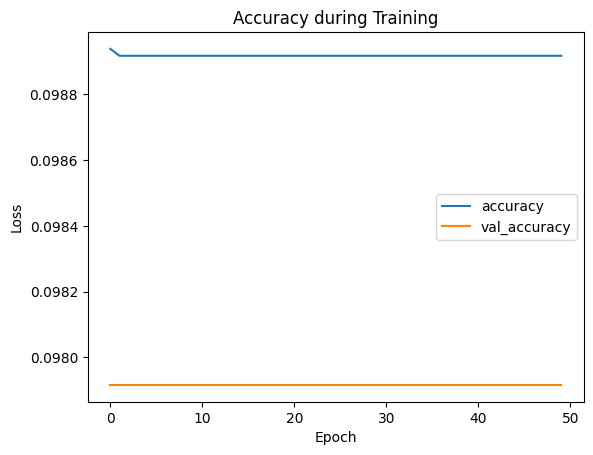

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy during Training")

In [11]:
train, test, train_y, test_y = train_test_split(datasets, labels, test_size=0.2, shuffle=False)
model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/kaggle/working/best_model.weights.h5')
history = model.fit(train, train_y, validation_data=(test, test_y), batch_size=128, epochs=50)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 311ms/step - accuracy: 0.0986 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 317ms/step - accuracy: 0.1000 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 114s 304ms/step - accuracy: 0.0992 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 116s 308ms/step - accuracy: 0.0998 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 150s 331ms/step - accuracy: 0.0985 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 116s 308ms/step - accuracy: 0.0988 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 121s 322ms/step - accuracy: 0.0972 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 115s 306ms/step - accuracy: 0.0989 - loss: nan - val_accuracy: 0.0995 - val_lo

Text(0.5, 1.0, 'Accuracy during Training')

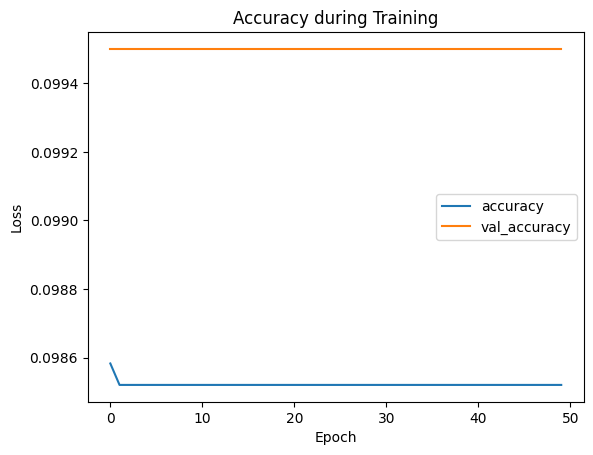

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy during Training")